Created on Wed Feb 06 11:34:21 2019 <br>
@author: zoldi.miklos
# <h1><center> Determining the effect of drift on misalignment of images taken by different filter cubes</center></h1>

Multi-color imaging using two separate fluorophores and filter cubes. Of course, there is chromatic aberration and the effect of filter cube change. But if these factors have small effect or have constant values and can be calculated and corrected in control experiments, changing filter cubes should be an OK solution. <br> <br>
However, the magnitude and direction of misalignment on biological samples seems to be non-uniform. Is it because the above factors do not give constant errors as because there are other factors to consider, for example the drift in the system? Both files are drift-corrected independently, but not in respect to each other! <br> <br>

What is the magnitude of the misalignment? How the drift in the system contributes to this? <br> Determine this on biological data, where Bassoon was labeled with one primary and with two secondary antibodies coupled to AF647 or CF568, and first far-red laser line was used with STORM cube, then red laser with RED cube (original strategy to overcome QUAD cube's crosstalk and bad quality imagings).
***


In [243]:
###import modules
import align_miki_v1_noarg as align #function for alignment
import os
import numpy as np
import pandas as pd; pd.set_option('max_rows', 3, 'max_colwidth',-1, 'max_columns', 20)
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns; sns.set(rc = {'figure.figsize' : (8.0, 6.0)})
from scipy import stats
import itertools
from sklearn.cluster import DBSCAN

In [235]:
###import and set display and plotting styles
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import ColumnDataSource, DataTable, TableColumn, HoverTool, PointDrawTool, \
Legend, Arrow, NormalHead, Range1d
from bokeh.models.annotations import Label
from bokeh.palettes import Blues, Oranges
from bokeh.layouts import row, Column
output_notebook(hide_banner=True)

In [14]:
###modified functions from align.py to match requirements
def load_2Channels(filename):
    '''read files and returns: drift corrected xyz coordinates as numpy array and the amount of xyz drift correction 
    xyz drift correction = drift corrected xyz - non-corrected xyz
    (opposite to the direction of the drift)'''
    
    dt = pd.read_csv(filename, delimiter='\t') #read as dataframes
    dt = dt[dt['Channel Name'].astype(str) != 'Z rejected'] 
    xyz_nc = dt[['Xw','Yw', 'Z']].values # convert to arrays (Use Z/Zc and not Zw/Zwc as the latter is not always drift corrected)
    xyz_c = dt[['Xwc','Ywc', 'Zc']].values #c = drift corrected xyz coord, nc = non-corrected
    #check amount of drift correction 
    xyz_driftCorr = xyz_c[-1] - xyz_nc[-1] #last row of array  (where drift should be maximal)
    return xyz_c, xyz_driftCorr


def prepare_2Channels(filename_1, filename_2, center_zoom_factor=0.25):
    '''load files and crop center of images
    the second image is also corrected by first image's drift correction''' 
    
    dt_1, xyz_driftCorr1 = load_2Channels(filename_1)
    dt_2, xyz_driftCorr2 = load_2Channels(filename_2) #amount of drift only needed for the first file 
    dt_2_driftCorr = dt_2 + xyz_driftCorr1
    
    box_1 = align.bounds(dt_1)
    box_2 = align.bounds(dt_2)
    box_2_driftCorr = align.bounds(dt_2_driftCorr)
    
    box = 0.33 * (box_1 + box_2 + box_2_driftCorr)
    box_center = 0.5 * (box[0, :] + box[1, :])
    box_edges = box[1, :] - box[0, :]
    factor = center_zoom_factor * 0.5
    crop_box = np.array([box_center - factor * box_edges,
                         box_center + factor * box_edges])
    dt_1 = align.crop_xy(dt_1, crop_box)
    dt_2 = align.crop_xy(dt_2, crop_box)
    dt_2_driftCorr = align.crop_xy(dt_2_driftCorr, crop_box)
    return dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1

***
# Determining empirical shift per file - aligning storm data manually
***

### -> load corresponding file pairs

In [309]:
### set variables: file locations, clustering parameters 
try:
    path = "L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/plot_offsets/"
    file_list = path + "_filenames_all.txt"
    dt = pd.read_csv(file_list, sep='\t', dtype=str)
    fred_path = "L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_FARRED//"
    red_path = "L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_RED//"         
except Exception as exc:
        print exc
        print "file listing filenames not found" 
        
dbscan_eps_1 = float(300),
dbscan_min_samples_1 = int(10),
dbscan_eps_2 = float(300),
dbscan_min_samples_2 = int(10),
border_size = float(200),
center_zoom_factor = float(0.25),
min_cluster_area_1 = 0,
max_cluster_area_1 = float(np.inf),
min_cluster_area_2 = 0,
max_cluster_area_2 = float(np.inf)
center_zoom_factor = 0.25

parameters = dict(
    dbscan_eps_1 = dbscan_eps_1,
    dbscan_min_samples_1 = dbscan_min_samples_1,
    dbscan_eps_2 = dbscan_eps_2,
    dbscan_min_samples_2 = dbscan_min_samples_2,
    border_size = border_size,
    center_zoom_factor = center_zoom_factor,
    min_cluster_area_1 = min_cluster_area_1,
    max_cluster_area_1 = max_cluster_area_1,
    min_cluster_area_2 = min_cluster_area_2,
    max_cluster_area_2 = max_cluster_area_2)
dt

,Nr,first,second
0,0,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_647_no405_list-2018-09-26-10-30-49_S01.bin_z_rejected.txt,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_568_no405_list-2018-09-27-20-06-53_S01.bin_z_rejected.txt
...,...,...,...
121,121,Gloxy_Sealed_Bas_AF647_CF568_sl03_90_s006_647_no405_list-2018-09-26-10-30-49_S124.bin_z_rejected.txt,Gloxy_Sealed_Bas_AF647_CF568_sl03_90_s006_568_no405_list-2018-09-27-20-06-53_S124.bin_z_rejected.txt


### -> Get first xyz coordinates of the cropped area for 568 (second file, to be shifted) and xyz drift correction for 647 (first file, reference)

In [16]:
###write out filename, first xyz coordinate of prepared 568 file, drift for 647
# data_out = np.empty((0,6)) #first xyz coord of 568, xyz drift for 647 
# filenames = []
# for index, row in dt.iterrows(): 
#     try:
#         file_1 = fred_path + row['first']
#         file_2 = red_path + row['second']   
#         dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1 = prepare_2Channels(file_1, file_2, parameters['center_zoom_factor'])
#         print row['first']
#     except:
#         print exc
#         print 'skipping file: ', dt_per_file['first'], 'and continuing the process'
#     filenames.append(file_1)
#     curr_data = np.append(dt_2[0,:], xyz_driftCorr1)
#     data_out = np.append(data_out,[curr_data], axis=0)
# #write to file
# filenames = pd.DataFrame(filenames, columns=['filename'])
# data_out = pd.DataFrame(data=data_out, columns=['x0_original_568', 'y0_original_568','z0_original_568', 
#                                              'x_drift_647','y_drift_647', 'z_drift_647'])

# data_out = pd.concat([filenames,data_out],axis=1)
# data_out.to_csv(file_list.replace('.txt','_first_xyz568_drift.txt'),sep='\t', index=False)
data_out = pd.read_csv(file_list.replace('_filenames_all.txt','_filenames_all_first_xyz568_drift.txt'),delimiter='\t')
data_out

,filename,x0_original_568,y0_original_568,z0_original_568,x_drift_647,y_drift_647,z_drift_647
0,L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_FARRED//Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_647_no405_list-2018-09-26-10-30-49_S01.bin_z_rejected.txt,22648.9,18140.0,-5.976,-30.5,5.1,-1.2210
...,...,...,...,...,...,...,...
121,L:/Miki/STORM_projects/Buffertests/180917_CF568_AF647_SAME_bassoon_imaging_time/analysis_FARRED//Gloxy_Sealed_Bas_AF647_CF568_sl03_90_s006_647_no405_list-2018-09-26-10-30-49_S124.bin_z_rejected.txt,21299.6,21455.1,-3.384,31.0,8.4,26.9972


### -> display the corresponding files, drag and align the 568 channel to the 647 channel. Changes in coordinates are displayed and this empirical shift can be determined. 

How-to: first select all of the points with the BoxSelect tool, zoom into the desired part, and clink on PointDrawTool. Pick 1 point, drag it, and all of the points will be dragged with it. If this needs correction, zoom out (or reset image), and select all of the points again. Otherwise only 1 point is dragged.

In [373]:
### figure for dragging second channel (568) to first channel by the user on individual files 
dt_per_file = dt.iloc[1] #select file 
#prepare file (read,crop)    
try:
    file_1 = fred_path + dt_per_file['first']
    file_2 = red_path + dt_per_file['second']   
    dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1 = prepare_2Channels(file_1, file_2, parameters['center_zoom_factor'])
except Exception as exc:
    print exc
    print 'skipping file: ', dt_per_file['first'], 'and continuing the process'

#plot data    
p = figure(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates', 
                height=500, width=800, tools = "box_select,wheel_zoom,pan,reset", active_drag='box_select')

#create sources from dataframes converted from numpy array of xyz coordinates 
dt_1_source = pd.DataFrame(dt_1, columns=['x','y','z'])
dt_2_source = pd.DataFrame(dt_2, columns=['x','y','z'])
# dt_2_source_original = dt_2_source.copy(deep=True)
source1 = ColumnDataSource(dt_1_source)
source2 = ColumnDataSource(dt_2_source)

#get 647 and 568 points 
renderer1 = p.scatter(x='x', y='y', source=source1, color='coral', size=5, legend ='647 - original')
renderer2 = p.scatter(x='x', y='y', source=source2, color='darkblue', size=5, legend ='568 - adjustable')

#get editable table with responsive 568 coordinates 
columns = [TableColumn(field="x", title="x"),
           TableColumn(field="y", title="y")]
table = DataTable(source=source2, columns=columns, editable=True, height=200) #edited even if editable=False??

#only renderer2 (568) is interactive for drag and drop
draw_tool = PointDrawTool(renderers=[renderer2], empty_value='black')
p.add_tools(draw_tool)

#edit plot style
table.width=200
p.x_range = Range1d(dt_1.min(axis=0)[0]-1000, dt_1.max(axis=0)[0]+1000) #adjust range to min-max x values
p.y_range = Range1d(dt_1.min(axis=0)[1]-1000, dt_1.max(axis=0)[1]+1000) #adjust range to min-max y values 
p.legend.click_policy='hide'
grid = gridplot([[p,table]], toolbar_location='above')
show(grid)

print "filename: ", dt_per_file['second']

filename:  Abbe_Sealed_Bas_AF647_CF568_sl01_120_s007_568_no405_list-2018-09-27-20-06-53_S02.bin_z_rejected.txt


### -> Alternative way: type the offset manually and display the original and offseted plots next to each other

Example offset, not the desired one!

In [377]:
### or shift coordinates by manually typing xyz shift and compare it with the original image
offset = np.array([10,-300,0]) #set xyz offset
dt_per_file = dt.iloc[1] #select file
#prepare file (read,crop)   
try:
    file_1 = fred_path + dt_per_file['first']
    file_2 = red_path + dt_per_file['second']   
    dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1 = prepare_2Channels(file_1, file_2, parameters['center_zoom_factor'])
except Exception as exc:
    print exc
    print 'skipping file: ', dt_per_file['first'], 'and continuing the process'
dt_2_shifted = dt_2.copy() #copy original dataset
dt_2_shifted = dt_2_shifted + offset #apply offset

fig_specs = dict(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates', 
                height=450, width=450)
#original
p1 = figure(**fig_specs)
a = p1.scatter(dt_1[:,0], dt_1[:,1], marker='circle', color='coral', legend ='647')
b = p1.scatter(dt_2[:,0], dt_2[:,1], marker='circle', color='darkblue', legend ='568 - original')
p1.legend.click_policy='hide'

#shifted
p2 = figure(x_range=p1.x_range, y_range=p1.y_range, **fig_specs)
a = p2.scatter(dt_1[:,0], dt_1[:,1], marker='circle', color='coral', legend ='647')
b = p2.scatter(dt_2_shifted[:,0], dt_2_shifted[:,1], marker='circle', color='darkblue', legend ='568 - shifted')
p2.legend.click_policy='hide'

grid = gridplot([[p1,p2]], toolbar_location='right')
show(grid)
print "filename: ", dt_per_file['second']
print "offset xyz: ", offset

filename:  Abbe_Sealed_Bas_AF647_CF568_sl01_120_s007_568_no405_list-2018-09-27-20-06-53_S02.bin_z_rejected.txt
offset xyz:  [  10 -300    0]


### -> get file with empirical offset values

In [19]:
dt_offsets = pd.read_excel(path+"_filenames_drifts_all.xlsx", delimiter='\t')
dt_offsets = dt_offsets[dt_offsets['could_align'] == 'yes'] #where I more or less could determine the alignment empirically 
dt_offsets

,Nr,first,second,x0_original_568,y0_original_568,z0_original_568,x0_drag,y0_drag,z0_drag,x_offset,y_offset,z_offset,x_drift_647,y_drift_647,z_drift_647,could_align
0,0,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_647_no405_list-2018-09-26-10-30-49_S01.bin_z_rejected.txt,Abbe_Sealed_Bas_AF647_CF568_sl01_105_s006_568_no405_list-2018-09-27-20-06-53_S01.bin_z_rejected.txt,22648.9,18140.0,-5.976,22630,18136.0,0,-18.9,-4.0,NaN,-30.5,5.1,-1.221,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,Gloxy_Sealed_Bas_AF647_CF568_sl02_75_s005_647_405_list-2018-09-26-10-30-49_S111.bin_z_rejected.txt,Gloxy_Sealed_Bas_AF647_CF568_sl02_75_s005_568_405_list-2018-09-27-20-06-53_S111.bin_z_rejected.txt,21422.4,17028.4,156.000,21410,17071.0,0,-12.4,42.6,NaN,-5.5,19.2,3.982,yes


***
# Displaying range of empirical xy offset values - trying different plotting styles
***
### -> scatterplot

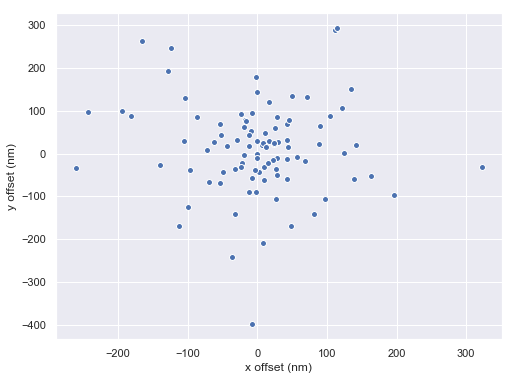

In [244]:
###plot x and y offset values as scatterplots
fig, ax = plt.subplots()
ax.scatter(dt_offsets['x_offset'],dt_offsets['y_offset'], marker='o', edgecolors='white')
# ax.set_aspect('equal')
# plt.xlim((-200,200)), plt.ylim((-200,200))
# plt.xticks(range(-300,350,50), rotation=45), plt.yticks(range(-300,350,50), rotation=45)
plt.xlabel('x offset (nm)')
plt.ylabel('y offset (nm)');

### -> kde density plots (on respective histogram) with rugplot

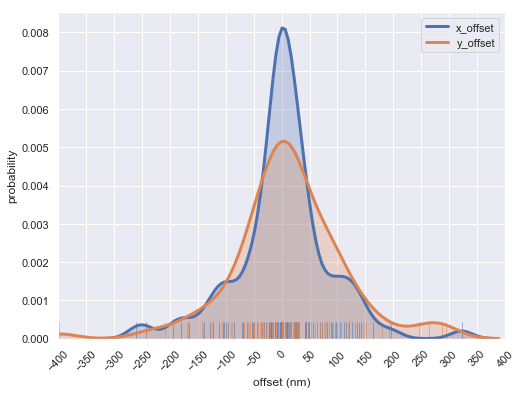

In [245]:
###plot both x and y offset values separately as shaded kde density plots (on their histograms)
# sns.set(rc={'figure.figsize':(10,5)}) #set figure size
for coordinate in ('x_offset', 'y_offset'):
    ax = sns.distplot(dt_offsets[coordinate], hist = False, kde = True, rug = True, label = coordinate,
                     kde_kws = {'shade': True, 'linewidth': 3}, rug_kws = {'linewidth': 0.5})
plt.xticks(range(-400,450,50), rotation=45)
plt.xlim((-400,400))
plt.ylabel('probability')
plt.xlabel('offset (nm)');

### -> bivariate kde density plot

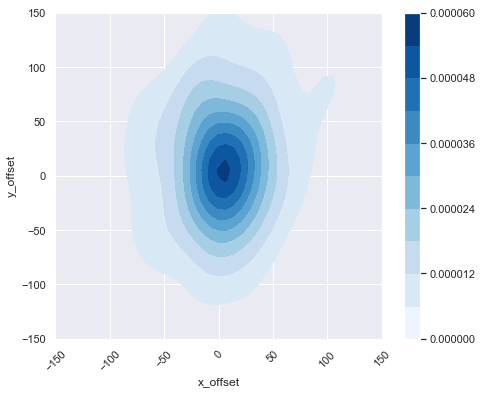

In [246]:
###plot x and y offsets as bivariate density plot - not displaying lowest probability
# sns.set(color_codes=True)
ax = sns.kdeplot(dt_offsets['x_offset'] , dt_offsets['y_offset'],  shade=True, shade_lowest=False, cmap="Blues", cbar=True)
ax.set_aspect('equal')
plt.xticks(range(-400,450,50), rotation=45)
plt.xlim((-150,150)), plt.ylim((-150,150));

### -> bivariate + univariate kde density plots; raw values scattered 

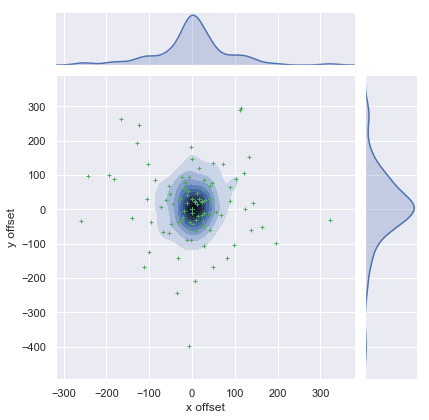

In [247]:
###plot every views :) 
g = sns.jointplot(x="x_offset", y="y_offset", data=dt_offsets, kind="kde", color="b")
g.plot_joint(plt.scatter, color="g", s=10, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("x offset", "y offset");

### -> 2d histogram

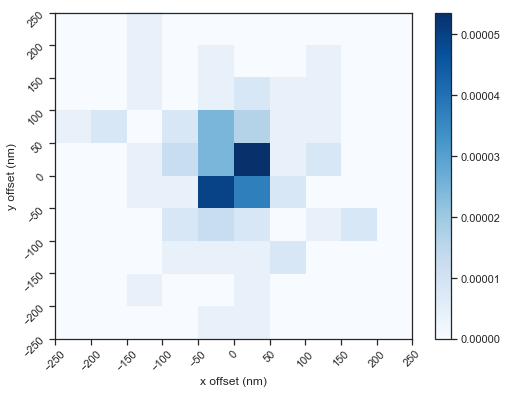

In [248]:
###2d histogram - temporally disable sns default darkgrid style; set to white with ticks
lim = (-250,250)
binwidth = 50
nbins = lim[1]/binwidth*2
#normalize histogram
# normed_x, edges_x= np.histogram(dt_offsets["x_offset"], bins=nbins, range=lim)
# normed_x = [i/float(np.sum(normed_x)) for i in normed_x]
# normed_y, edges_y= np.histogram(dt_offsets["y_offset"], bins=nbins, range=lim)
# normed_y = [i/float(np.sum(normed_y)) for i in normed_y]
# normed_x, normed_y
with sns.axes_style("ticks"):
    plt.hist2d(x="x_offset", y="y_offset", data=dt_offsets, bins=(nbins, nbins), range=(lim,lim), normed=True, cmap=plt.cm.Blues) 
    plt.colorbar()
    plt.xticks(range(lim[0],lim[1]+binwidth, binwidth), rotation=45)
    plt.yticks(range(lim[0],lim[1]+binwidth, binwidth), rotation=45)
    plt.xlim(lim), plt.ylim(lim)
    plt.xlabel('x offset (nm)'), plt.ylabel('y offset (nm)')

***
# -> Do offset values correlate with drift in system??
***

### -> Correlation between offset determined by manual drag (568 -> 647) and drift correction of the first file (647)

In [97]:
###figure to check whether drift correction correlates with empirical offset determined by dragging plots 
###separately for X and Y coordinates 
p1 = figure(match_aspect=True, x_axis_label='X offset (nm)', y_axis_label='X drift correction (nm)', 
            height=400, width=400)
p1.circle(x="x_offset", y="x_drift_647", source= dt_offsets, color='darkgreen')

p2 = figure(match_aspect=True, x_axis_label='Y offset (nm)', y_axis_label='Y drift correction (nm)', 
            height=400, width=400)
p2.circle(x="y_offset", y="y_drift_647", source=dt_offsets, color='purple')

###estimate correlation
gradient_X, intercept_X, rValue_X, pValue_X, stdErr_X = stats.linregress(dt_offsets['x_offset'], dt_offsets['x_drift_647'])
gradient_Y, intercept_Y, rValue_Y, pValue_Y, stdErr_Y = stats.linregress(dt_offsets['y_offset'], dt_offsets['y_drift_647'])
###plot fitted 
p1.line(x=dt_offsets['x_drift_647'], y=(intercept_X + gradient_X*dt_offsets['x_drift_647']), 
        color='darkgreen', line_width=2, line_alpha=0.6)
p2.line(x=dt_offsets['y_drift_647'], y=(intercept_Y + gradient_Y*dt_offsets['y_drift_647']), 
        color='purple', line_width=2, line_alpha=0.6)
###show plot
grid = gridplot([[p1, p2]])
show(grid)
###print data
print "X-coordinate - slope: %f \t r-squared: %f" % (gradient_X, rValue_X**2)
print "Y-coordinate - slope: %f \t r-squared: %f" % (gradient_Y, rValue_Y**2)

X-coordinate - slope: 0.524570 	 r-squared: 0.659229
Y-coordinate - slope: 0.533213 	 r-squared: 0.820390


### -> So correcting for first file's drift should reduce the extent of offset??!!

In [77]:
###get original and drift corrected offsets for easier handling
x_offset, y_offset = dt_offsets['x_offset'].values, dt_offsets['y_offset'].values
x_drift, y_drift = dt_offsets['x_drift_647'].values, dt_offsets['y_drift_647'].values
x_offset_corr, y_offset_corr = x_offset - x_drift, y_offset - y_drift

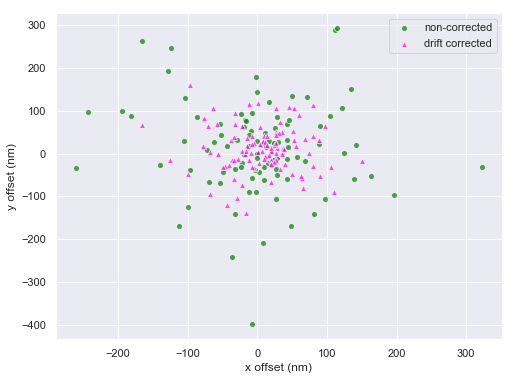

In [249]:
###plot x and y offset values as scatterplots
fig, ax = plt.subplots()
ax.scatter(x_offset, y_offset, marker='o', color='green', edgecolors='white', alpha=0.7, label='non-corrected')
ax.scatter(x_offset_corr, y_offset_corr, marker='^', color='magenta', edgecolors='white', alpha=0.7, label='drift corrected')
plt.legend()
plt.xlabel('x offset (nm)')
plt.ylabel('y offset (nm)');

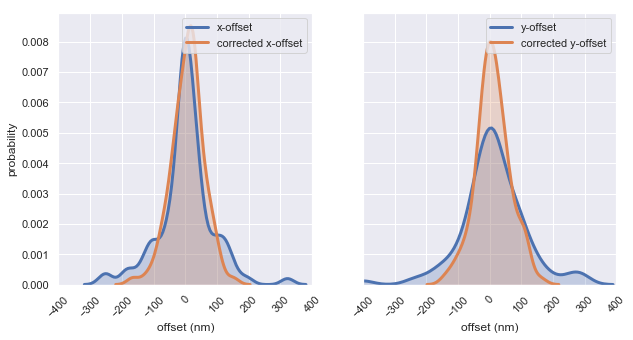

In [250]:
###plot both x and y offset values separately as shaded kde density plots (on their histograms)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

for offset, label in zip ([x_offset, x_offset_corr], ["x-offset","corrected x-offset"]):
    sns.distplot(offset, ax=ax1, hist = False, kde = True, label = label, kde_kws = {'shade': True, 'linewidth': 3})
for offset, label in zip ([y_offset,y_offset_corr], ["y-offset","corrected y-offset"]):
    sns.distplot(offset, ax=ax2, hist = False, kde = True, label = label, kde_kws = {'shade': True, 'linewidth': 3})


#iterate through axes and set tha axis as the current plot's axis
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(range(-400,450,100), rotation=45)
    plt.xlim((-400,400))
    plt.xlabel('offset (nm)')
    plt.legend(loc='upper right')
#applied only for first axis
ax1.set_ylabel('probability');

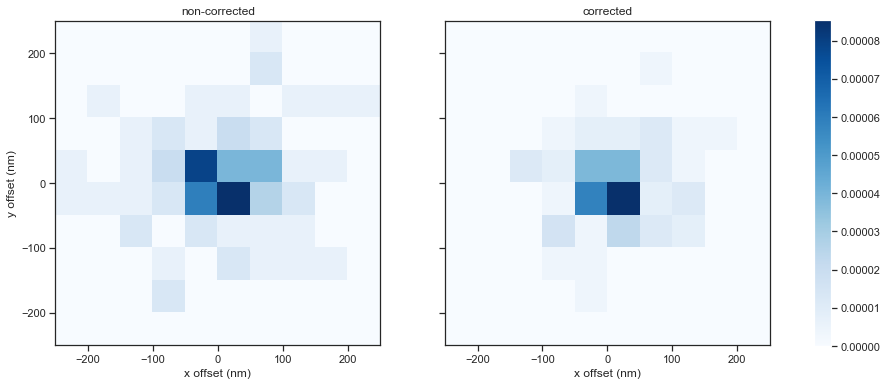

In [273]:
###2d histogram - temporally disable sns default darkgrid style; set to white with ticks
lim = (-250,250)
binwidth = 50
nbins = lim[1]/binwidth*2
with sns.axes_style("ticks"):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,6))
    for ax,x,y,legend in zip (fig.axes, [x_offset, x_offset_corr], [y_offset, y_offset_corr], 
                              ["non-corrected", "corrected"]):
        plt.sca(ax)
        hist, xedges, yedges = np.histogram2d(x=x, y=y, bins=(nbins, nbins), range=(lim,lim), normed=True) 
        im = ax.imshow(hist, extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]], cmap=plt.cm.Blues)
        plt.xlabel('x offset (nm)')
        ax.set_title(legend)
ax1.set_ylabel('y offset (nm)')
fig.colorbar(im, ax=[ax1, ax2]);

***
# Drug - ligand images on cells from Susanne
***

In [332]:
S_path = "L:/Zsuzska/DRD3/phs/ABP535/PD-kiserletek/190123//" #s / cf
S_fredPath = S_path + "190123-s//"
S_redPath= S_path + "190123-cf//"
S_fredFiles = os.listdir(S_fredPath)
S_fredFiles = [i for i in S_fredFiles if i.endswith(".bin.txt")] 
S_redFiles = os.listdir(S_redPath)
S_redFiles = [i for i in S_redFiles if i.endswith(".bin.txt")] 
# ### or for combined files
# import os 
# S_path = "L:/Zsuzska/DRD3/phs/ABP535/PD-kiserletek/190123//" #s / cf
# S_combinedPath = S_path + "190123-analizis//"
# S_combinedFiles = os.listdir(S_combinedPath)
# S_combinedFiles = [i for i in S_combinedFiles if i.endswith("RoiCoords.txt")] 
S_dt = pd.DataFrame(data={'first':S_fredFiles, 'second':S_redFiles})
S_dt

,first,second
0,190123-HEK-A535-7-PD0-s001_list-2019-01-23-17-30-31_S22.bin.txt,190123-HEK-A535-7-PD0-cf001_list-2019-01-23-17-39-49_S22.bin.txt
...,...,...
12,190124-from23-A5357-PD8-s002_list-2019-01-27-12-13-58_S13.bin.txt,190124-from23-A5357-PD8-cf002_list-2019-01-27-13-40-20_S13.bin.txt


In [349]:
#generated excel as above from Susanne's files, will use the whole area not the cropped one for alignment
S_data_out = pd.read_excel(path + '_Susannesfilenames_drifts_all.xlsx',delimiter='\t')
S_data_out.loc[:, S_data_out.columns != 'filename'] #without long filenames

,Nr,x0_original_568,y0_original_568,z0_original_568,x0_drag,y0_drag,z0_drag,x_offset,y_offset,z_offset,x_drift_647,y_drift_647,z_drift_647,could_align
0,0,21754.7,20538.9,-71.7715,21514,20452,0,-240.7,-86.9,0,-73.9,-51.2,33.791,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,12,18805.1,20792.4,104.0000,0,0,0,-18805.1,-20792.4,0,14.7,45.8,73.637,yes


In [378]:
### figure for dragging second channel (568) to first channel by the user on individual files 
def drag_storm_points (file_1, file_2, function=prepare_2Channels, crop_area=0.25):    
    ''' plot two storm channels and make second storm pointlist draggable

    file_1 (647) and file_2 (568) should be absolute path to storm coordinate files
    function: need to be invoked in advance
    crop area: area of image to be cropped from the center
    
    displays: draggable plot, xy coordinates of dragged storm points'''
    #prepare file (read,crop)    
    try:
        dt_1, dt_2, dt_2_driftCorr, xyz_driftCorr1 = function(file_1, file_2, crop_area) #get bigger center zoom factor
    except Exception as exc:
        print exc
        print 'skipping file: ', dt_per_file['first'], 'and continuing the process'

    #plot data    
    p = figure(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates', 
                    height=500, width=800, tools = "box_select,wheel_zoom,pan,reset", active_drag='box_select')

    #create sources from dataframes converted from numpy array of xyz coordinates 
    dt_1_source = pd.DataFrame(dt_1, columns=['x','y','z'])
    dt_2_source = pd.DataFrame(dt_2, columns=['x','y','z'])
    # dt_2_source_original = dt_2_source.copy(deep=True)
    source1 = ColumnDataSource(dt_1_source)
    source2 = ColumnDataSource(dt_2_source)

    #get 647 and 568 points 
    renderer1 = p.scatter(x='x', y='y', source=source1, color='coral', size=5, legend ='647 - original')
    renderer2 = p.scatter(x='x', y='y', source=source2, color='darkblue', size=5, legend ='568 - adjustable')

    #get editable table with responsive 568 coordinates 
    columns = [TableColumn(field="x", title="x"),
               TableColumn(field="y", title="y")]
    table = DataTable(source=source2, columns=columns, editable=True, height=200) #edited even if editable=False??

    #only renderer2 (568) is interactive for drag and drop
    draw_tool = PointDrawTool(renderers=[renderer2], empty_value='black')
    p.add_tools(draw_tool)

    #edit plot style
    table.width=200
    p.x_range = Range1d(dt_1.min(axis=0)[0]-1000, dt_1.max(axis=0)[0]+1000) #adjust range to min-max x values
    p.y_range = Range1d(dt_1.min(axis=0)[1]-1000, dt_1.max(axis=0)[1]+1000) #adjust range to min-max y values 
    p.legend.click_policy='hide'
    grid = gridplot([[p,table]], toolbar_location='above')
    show(grid)

    print "filename: ", file_2

In [379]:
dt_per_file = S_dt.iloc[0] #select file 
file_1 = S_fredPath + dt_per_file['first']
file_2 = S_redPath + dt_per_file['second'] 
drag_storm_points (file_1, file_2, function=prepare_2Channels, crop_area=1)

filename:  L:/Zsuzska/DRD3/phs/ABP535/PD-kiserletek/190123//190123-cf//190123-HEK-A535-7-PD0-cf001_list-2019-01-23-17-39-49_S22.bin.txt


### -> Calculate shifts on these files as well! Here alignment is not so obvious at all!

### Conclusions
- misalignment on my bassoon data seems to be less than 100 nm in xy dimension. It is quite a good estimate as it is likely that NOT the very same epitopes are labeled due to steric hindrance of antibodies
- correcting for drift can even reduce this problem, especially if drift is big enough
- optical offset may be a constant value, which can be determined before imagings. Correction should be done one beads embedded in agarose, as in Erdélyi et al., 2013, to get the depth-dependance of this offset. 
- any change in the miscroscope can change this calculated offset. Maybe this has to be done every time when filter cube was taken out for cleaning. This could be one of the the reasons why we saw different offset values.